In [2]:
import pandas as  pd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import train_test_split

### Visualize data (each image size (275, 347, 245))

Text(0.5, 1.0, 'Gray matter (Traverse)')

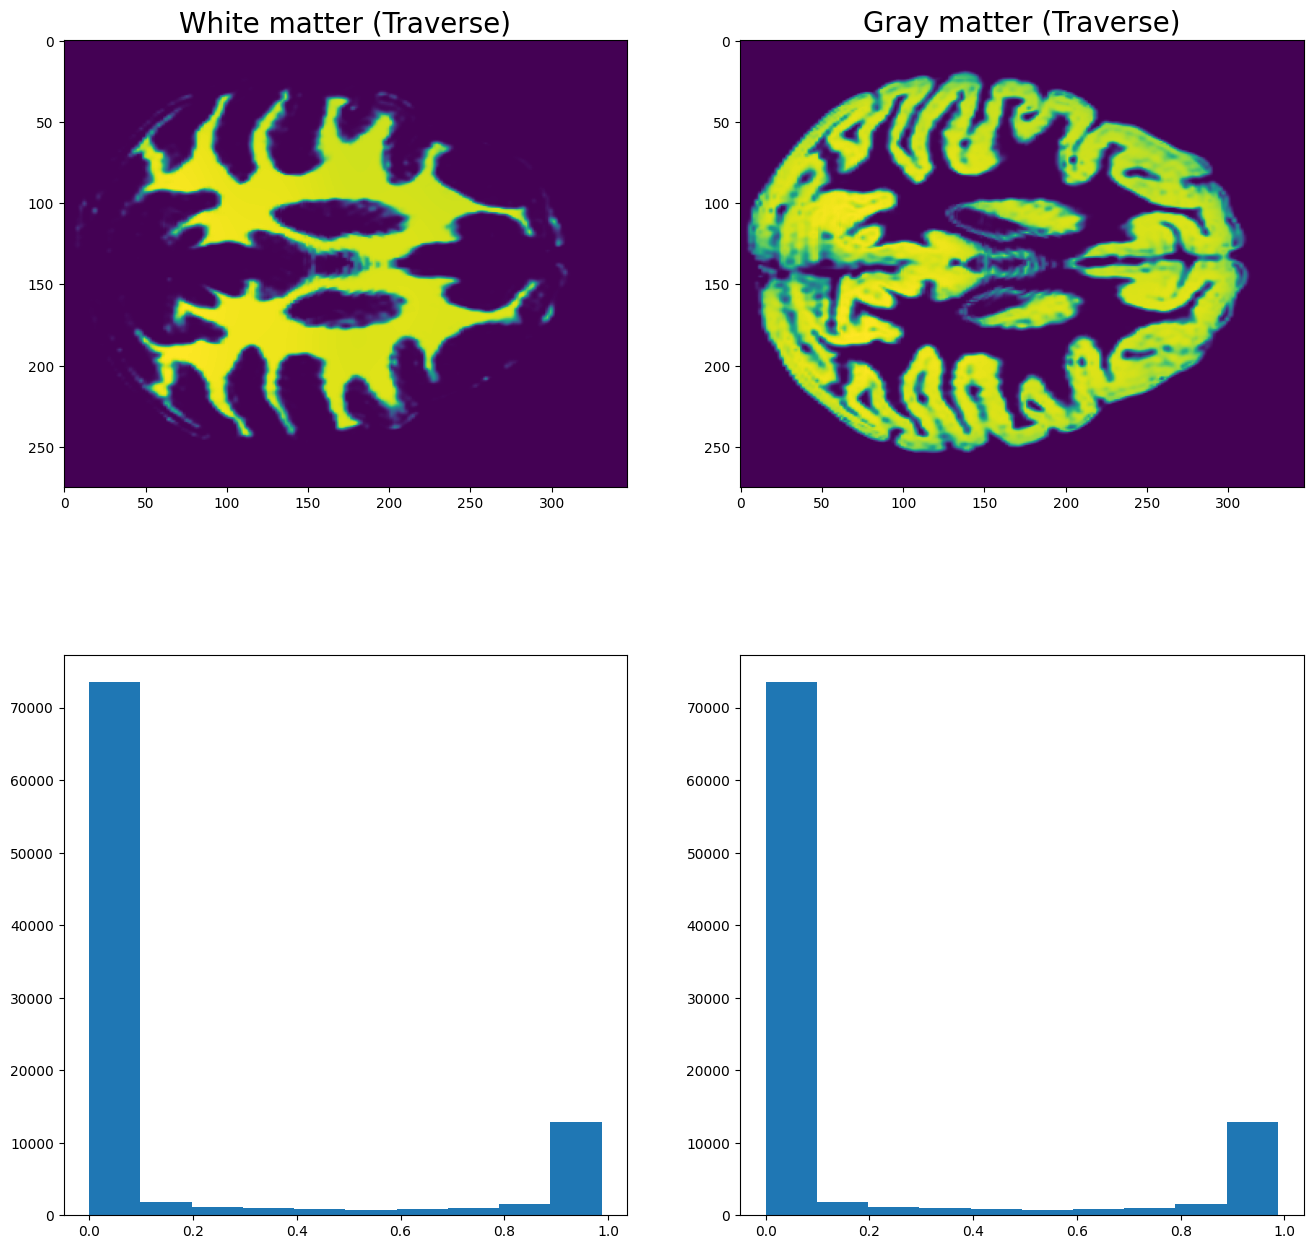

In [3]:
slice = 150
demo_filepath_whitematter = '/cis/home/jdey4/spmmouse_segment/sub-1001/mwc2T1w_brain.nii.gz'
demo_filepath_graymatter = '/cis/home/jdey4/spmmouse_segment/sub-1001/mwc1T1w_brain.nii.gz'

img_whitematter = nb.load(demo_filepath_whitematter).get_fdata()
sliced_img_whitematter = img_whitematter[:,:,slice]

img_graymatter = nb.load(demo_filepath_graymatter).get_fdata()
sliced_img_graymatter = img_graymatter[:,:,slice]

fig, ax = plt.subplots(2,2, figsize=(16,16))
ax[0][0].imshow(sliced_img_whitematter)
ax[0][1].imshow(sliced_img_graymatter)
ax[1][0].hist(sliced_img_whitematter.reshape(-1))
ax[1][1].hist(sliced_img_whitematter.reshape(-1))

ax[0][0].set_title('White matter (Traverse)', fontsize=20)
ax[0][1].set_title('Gray matter (Traverse)', fontsize=20)

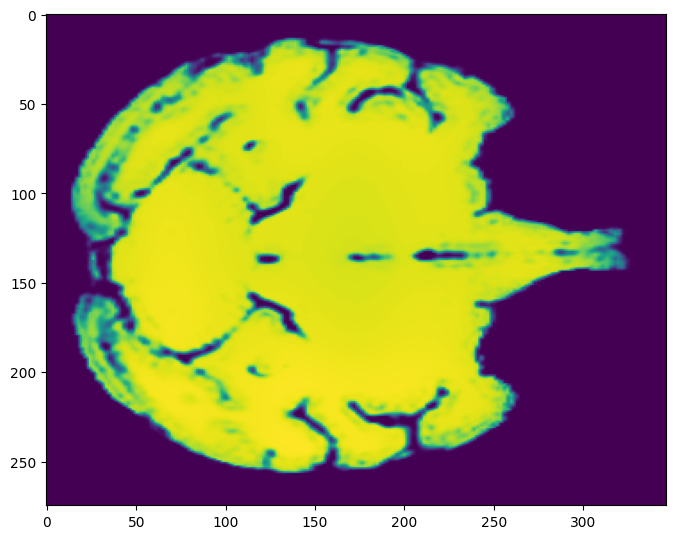

In [4]:
img = img_whitematter + img_graymatter

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(img[:,:,100])

### Analyze class distribution and age 

In [5]:
df = pd.read_csv('/cis/home/jdey4/spmmouse_segment/uwmadison.csv')
df.head()

,participant_id,age,sex
0,sub-1001,1.756164,M
1,sub-1002,1.783562,F
2,sub-1003,1.756164,M
3,sub-1004,1.756164,M
4,sub-1005,1.742466,M


Text(0, 0.5, 'Age')

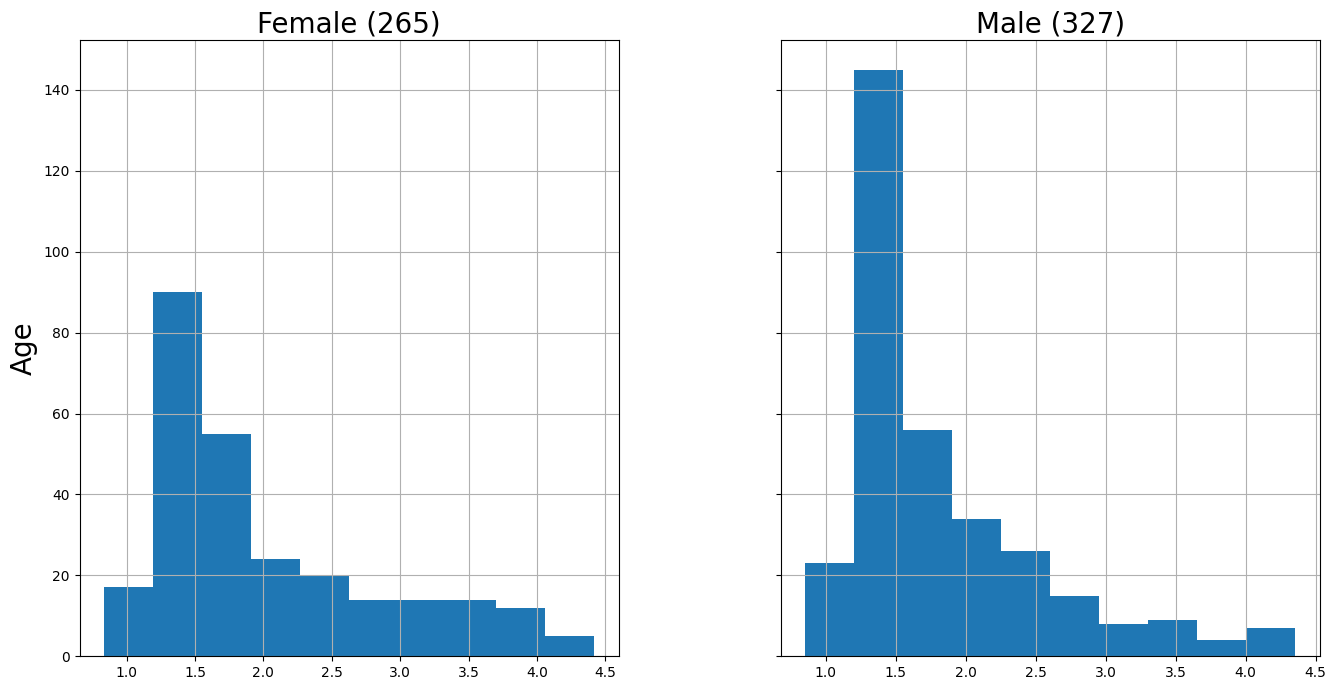

In [6]:
fig, ax = plt.subplots(1,2, figsize=(16,8), sharey=True)

total_female = len(df[df['sex']=='F'])
total_male = len(df[df['sex']=='M'])

df[df['sex']=='F'].hist(ax=ax[0])
df[df['sex']=='M'].hist(ax=ax[1])

ax[0].set_title('Female ('+str(total_female)+')', fontsize=20)
ax[1].set_title('Male ('+str(total_male)+')', fontsize=20)

ax[0].set_ylabel('Age', fontsize=20)

### Load data and build (feature, label)

In [7]:
path = '/cis/home/jdey4/spmmouse_segment/'
subjects = os.listdir(path)
X = []
y = []
IDs = set(df['participant_id'])
for subject in tqdm(subjects):
    if subject in IDs:
        #print(df[df['ID']==subject]['Sex'])
        sex = int(df[df['participant_id']==subject]['sex'].item()=='F')
        current_file = os.path.join(path, subject)
        tmp = []
        save = True
        for file in glob.glob(current_file+'/*'):
            try:
                img = nb.load(file).get_fdata()
                #print(img.shape)
                tmp.append(img.reshape(-1))
            except:
                save = False
                print(file,' corrupted')

        '''if len(tmp)<2:
            print(subject, ' has less files')'''
            
        if save and len(tmp)==2:
            #X.append(np.sum(tmp,axis=0))
            X.append(np.array(tmp).reshape(1,-1))
            y.append(sex)

    else:
        print(subject, " missing")
#X = np.array(X)
X = np.concatenate(X,axis=0)

 15%|█████████▌                                                    | 90/586 [02:37<14:30,  1.76s/it]

.DS_Store  missing


 17%|██████████▌                                                  | 101/586 [02:53<12:13,  1.51s/it]

uwmadison.csv  missing


100%|█████████████████████████████████████████████████████████████| 586/586 [17:39<00:00,  1.81s/it]


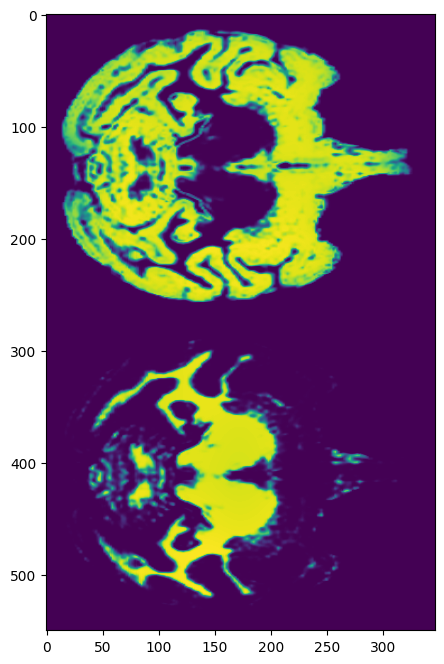

In [8]:
img = X[0]
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(img.reshape(275*2, 347, 245)[:,:,100])

In [9]:
X.shape

(572, 46758250)

In [10]:
np.mean(y)

0.4527972027972028

In [ ]:
reps = 10
accuracy = 0.0

for _ in tqdm(range(reps)):
    x_train, x_test, y_train, y_test = train_test_split(
                    X, y, train_size=0.8, random_state=0, stratify=y)
    clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
    clf.fit(x_train,y_train)
    accuracy += np.mean(clf.predict(x_test)==y_test)

print('Accuracy is ',accuracy/reps)

  0%|                                                                        | 0/10 [00:00<?, ?it/s]